# Normalized Attention Guidance

paper: https://arxiv.org/abs/2505.21179

project page: https://chendaryen.github.io/NAG.github.io/

Hugging Face Demo: https://huggingface.co/spaces/ChenDY/NAG_FLUX.1-schnell and https://huggingface.co/spaces/ChenDY/NAG_FLUX.1-dev

In [ ]:
!pip install git+https://github.com/ChenDarYen/Normalized-Attention-Guidance.git

In [ ]:

from nag import NAGStableDiffusionXLPipeline


In [ ]:
import torch
import sys
import os
from PIL import Image

from diffusers import UNet2DConditionModel, LCMScheduler
from huggingface_hub import hf_hub_download

# Add the workspace directory to sys.path
workspace_dir = '/home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance'
if workspace_dir not in sys.path:
    sys.path.insert(0, workspace_dir)

from nag import NAGStableDiffusionXLPipeline

base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
repo_name = "tianweiy/DMD2"
ckpt_name = "dmd2_sdxl_4step_unet_fp16.bin"

unet = UNet2DConditionModel.from_config(base_model_id, subfolder="unet").to("cuda", torch.bfloat16)
unet.load_state_dict(torch.load(hf_hub_download(repo_name, ckpt_name), map_location="cuda"))
pipe = NAGStableDiffusionXLPipeline.from_pretrained(
    base_model_id,
    unet=unet,
    torch_dtype=torch.bfloat16,
    variant="fp16",
).to("cuda")
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config, original_inference_steps=4)

prompt = "A portrait of an older female librarian"
nag_negative_prompt = "glasses, eyewear, spectacles"

image = pipe(
    prompt,
    nag_negative_prompt=nag_negative_prompt,
    guidance_scale=0,
    nag_scale=3,
    num_inference_steps=4,
).images[0]

image

In [ ]:
import torch
from PIL import Image
from diffusers import UNet2DConditionModel, LCMScheduler, StableDiffusionXLPipeline
from huggingface_hub import hf_hub_download

from nag import NAGStableDiffusionXLPipeline

device = "cuda"
dtype = torch.bfloat16

base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
repo_name = "tianweiy/DMD2"
ckpt_name = "dmd2_sdxl_4step_unet_fp16.bin"

# --- NAG pipeline (uses nag_negative_prompt + nag_scale) ---
unet_nag = UNet2DConditionModel.from_config(base_model_id, subfolder="unet").to(device, dtype)
unet_nag.load_state_dict(torch.load(hf_hub_download(repo_name, ckpt_name), map_location=device))
pipe_nag = NAGStableDiffusionXLPipeline.from_pretrained(
    base_model_id, unet=unet_nag, torch_dtype=dtype, variant="fp16"
).to(device)
pipe_nag.scheduler = LCMScheduler.from_config(pipe_nag.scheduler.config, original_inference_steps=4)

# --- Standard SDXL baseline (uses negative_prompt) ---
pipe_std = StableDiffusionXLPipeline.from_pretrained(
    base_model_id, torch_dtype=dtype, variant="fp16"
).to(device)
pipe_std.scheduler = LCMScheduler.from_config(pipe_std.scheduler.config, original_inference_steps=4)

prompt = "A portrait of an older female librarian"
block_glasses = "glasses, eyewear, spectacles"
seeds = [2047, 2107]

STEPS = 4
LCM_CFG = 1.0      # good range for LCMs: ~0.8–1.5
NAG_SCALE = 3.0    # 2–5 typically

rows = []
for s in seeds:
    g = torch.Generator(device=device).manual_seed(s)

    # 1) NAG, no NAG negatives (pure LCM sample)
    img_nag_plain = pipe_nag(
        prompt, guidance_scale=LCM_CFG, generator=g, num_inference_steps=STEPS
    ).images[0]

    # 2) STD, no negatives (pure LCM sample)
    g = torch.Generator(device=device).manual_seed(s)
    img_std_plain = pipe_std(
        prompt, guidance_scale=LCM_CFG, generator=g, num_inference_steps=STEPS
    ).images[0]

    # 3) NAG with NAG negatives (use nag_negative_prompt + nag_scale; CFG can be 0 or small)
    g = torch.Generator(device=device).manual_seed(s)
    img_nag_block = pipe_nag(
        prompt,
        nag_negative_prompt=block_glasses,  # <-- NAG hook
        nag_scale=NAG_SCALE,                # <-- strength
        guidance_scale=0.0,                 # NAG usually run with CFG off
        num_inference_steps=STEPS,
        generator=g,
    ).images[0]

    # 4) STD with normal negative_prompt (works, but weaker at 4 steps)
    g = torch.Generator(device=device).manual_seed(s)
    img_std_block = pipe_std(
        prompt,
        negative_prompt=block_glasses,      # <-- standard CFG negative
        guidance_scale=LCM_CFG,
        num_inference_steps=STEPS,
        generator=g,
    ).images[0]

    rows.append([img_nag_plain, img_std_plain, img_nag_block, img_std_block])

# Display the results as a grid
# Create a comparison grid: 2 rows × 4 columns
# Columns: NAG plain, STD plain, NAG block, STD block
# Rows: Seed 1, Seed 2

img_height, img_width = rows[0][0].height, rows[0][0].width
grid = Image.new('RGB', (img_width * 4, img_height * 2))

# Place images in grid
for row_idx, row_images in enumerate(rows):
    for col_idx, img in enumerate(row_images):
        grid.paste(img, (col_idx * img_width, row_idx * img_height))

# Display with labels
print("Comparison Grid Layout:")
print("Column 1: NAG (no negatives) | Column 2: STD (no negatives)")
print("Column 3: NAG + blocking     | Column 4: STD + blocking")
print(f"Row 1: Seed {seeds[0]} | Row 2: Seed {seeds[1]}")
grid

In [ ]:
import torch
from PIL import Image
from diffusers import (
    UNet2DConditionModel,
    StableDiffusionXLPipeline,
    EulerDiscreteScheduler,
)
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

from nag import NAGStableDiffusionXLPipeline

# ---------- Config ----------
device = "cuda"
weights_dtype = torch.bfloat16
basemodel_id = "stabilityai/stable-diffusion-xl-base-1.0"

# Lightning (4-step) distilled UNet
lightning_repo = "ByteDance/SDXL-Lightning"
lightning_ckpt = "sdxl_lightning_4step_unet.safetensors"  # ensure this matches your intended steps

# ---------- Base model & Euler scheduler ----------
base_unet = UNet2DConditionModel.from_pretrained(
    basemodel_id, subfolder="unet"
).to(device, weights_dtype)

pipe = StableDiffusionXLPipeline.from_pretrained(
    basemodel_id, unet=base_unet, torch_dtype=weights_dtype, use_safetensors=True
).to(device)

# Make the base scheduler Euler as well
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
base_scheduler = pipe.scheduler  # kept for reference/consistency

# ---------- SDXL-Lightning distilled UNet ----------
distilled_unet = UNet2DConditionModel.from_config(  # typo fixed below (UNet2DConditionModel)
    basemodel_id, subfolder="unet"
).to(device, weights_dtype)
distilled_unet.load_state_dict(load_file(hf_hub_download(lightning_repo, lightning_ckpt), device=device))

# ---------- NAG & STD pipelines (both Euler, trailing) ----------
pipe_nag = NAGStableDiffusionXLPipeline.from_pretrained(
    basemodel_id, unet=distilled_unet, torch_dtype=weights_dtype, variant="fp16", use_safetensors=True
).to(device)
pipe_nag.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

pipe_std = StableDiffusionXLPipeline.from_pretrained(
    basemodel_id, unet=distilled_unet, torch_dtype=weights_dtype, variant="fp16", use_safetensors=True
).to(device)
pipe_std.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

# ---------- Prompts, seeds, and settings ----------
prompt = "A portrait of an older female librarian"
block_glasses = "glasses, eyewear, spectacles"
seeds = [2047, 2107, 2207, 2307]

STEPS = 4                 # matches 4-step Lightning ckpt
LIGHTNING_CFG = 0.0       # Lightning is typically run with CFG ~0
NAG_SCALE = 3.0           # 2–5 typical
STD_BLOCKING_CFG = 1.0    # small CFG so negative_prompt has effect

rows = []
for s in seeds:
    # 1) NAG (Lightning UNet), no NAG negatives (pure Lightning sample)
    g = torch.Generator(device=device).manual_seed(s)
    img_nag_plain = pipe_nag(
        prompt, guidance_scale=LIGHTNING_CFG, generator=g, num_inference_steps=STEPS
    ).images[0]

    # 2) STD (Lightning UNet), no negatives (pure Lightning sample)
    g = torch.Generator(device=device).manual_seed(s)
    img_std_plain = pipe_std(
        prompt, guidance_scale=LIGHTNING_CFG, generator=g, num_inference_steps=STEPS
    ).images[0]

    # 3) NAG with NAG negatives (CFG off)
    g = torch.Generator(device=device).manual_seed(s)
    img_nag_block = pipe_nag(
        prompt,
        nag_negative_prompt=block_glasses,
        nag_scale=NAG_SCALE,
        guidance_scale=0.0,
        num_inference_steps=STEPS,
        generator=g,
    ).images[0]

    # 4) STD with normal negative_prompt (small CFG so it bites a little)
    g = torch.Generator(device=device).manual_seed(s)
    img_std_block = pipe_std(
        prompt,
        negative_prompt=block_glasses,
        guidance_scale=STD_BLOCKING_CFG,
        num_inference_steps=STEPS,
        generator=g,
    ).images[0]

    rows.append([img_nag_plain, img_std_plain, img_nag_block, img_std_block])

# ---------- Assemble comparison grid (2 rows × 4 cols) ----------
img_height, img_width = rows[0][0].height, rows[0][0].width
grid = Image.new('RGB', (img_width * 4, img_height * 4))
for row_idx, row_images in enumerate(rows):
    for col_idx, img in enumerate(row_images):
        grid.paste(img, (col_idx * img_width, row_idx * img_height))

print("Comparison Grid Layout (Euler everywhere; SDXL-Lightning 4-step):")
print("Column 1: NAG (no negatives) | Column 2: STD (no negatives)")
print("Column 3: NAG + blocking     | Column 4: STD + blocking")
print(f"Row 1: Seed {seeds[0]} | Row 2: Seed {seeds[1]} | Row 3: Seed {seeds[2]} | Row 4: Seed {seeds[3]}")
grid


In [ ]:
# Impactful NAG: timed variant with soft-start and end control
# Usage notes:
#   - Start with nag_start=0.17–0.25 for object deletion; 0.30–0.40 for adjective/style negatives
#   - Leave nag_ramp_steps=0 unless you see a small quality dip right after the start; then try nag_ramp_steps=3
#   - Your existing nag_end keeps working; default 1.0 means "keep NAG on to the end"

import torch
import sys
from PIL import Image
from diffusers import (
    UNet2DConditionModel,
    StableDiffusionXLPipeline,
    EulerDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
)
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

# Add the workspace directory to sys.path
workspace_dir = '/home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance'
if workspace_dir not in sys.path:
    sys.path.insert(0, workspace_dir)


from nag import ImpactfulNAGStableDiffusionXLPipeline

# ---------- Config ----------
device = "cuda"
weights_dtype = torch.bfloat16
basemodel_id = "stabilityai/stable-diffusion-xl-base-1.0"

# Turbo UNet source
turbo_repo = "stabilityai/sdxl-turbo"
turbo_subfolder = "unet"

# ---------- Base model (to borrow scheduler config) ----------
base_pipe_for_cfg = StableDiffusionXLPipeline.from_pretrained(
    basemodel_id, torch_dtype=weights_dtype, use_safetensors=True
)
base_sched_config = base_pipe_for_cfg.scheduler.config
del base_pipe_for_cfg  # keep VRAM tidy

# ---------- SDXL-Turbo distilled UNet ----------
distilled_unet = UNet2DConditionModel.from_pretrained(
    turbo_repo, subfolder=turbo_subfolder, torch_dtype=weights_dtype, variant="fp16"
).to(device, weights_dtype)

# ---------- Pipelines (EulerA for Turbo, trailing timesteps) ----------
pipe_impactful_nag_turbo = ImpactfulNAGStableDiffusionXLPipeline.from_pretrained(
    basemodel_id, unet=distilled_unet, torch_dtype=weights_dtype, variant="fp16", use_safetensors=True
).to(device)
pipe_impactful_nag_turbo.scheduler = EulerAncestralDiscreteScheduler.from_config(
    base_sched_config, timestep_spacing="trailing"
)

pipe_std_turbo = StableDiffusionXLPipeline.from_pretrained(
    basemodel_id, unet=distilled_unet, torch_dtype=weights_dtype, variant="fp16", use_safetensors=True
).to(device)
pipe_std_turbo.scheduler = EulerAncestralDiscreteScheduler.from_config(
    base_sched_config, timestep_spacing="trailing"
) 

# ---------- Prompts, seeds, and settings ----------
prompt = "Hipster coffee shop worker"
block_glasses = "beard, stubble"
seeds = [2047, 2107, 2207, 2307, 2407, 2507]

STEPS = 4               # Turbo supports 1–4 steps; keep 4 to match your Lightning grid
TURBO_CFG = 0.0         # ADD-style; typically run with CFG ~0

# Impactful NAG timing parameters
NAG_START = 0.20        # Delay NAG start to 20% of trajectory (for object deletion)
                        # Try 0.30–0.40 for adjective/style negatives
NAG_RAMP_STEPS = 0      # Leave at 0 unless quality dip; try 3 if needed
NAG_SCALE = 3.0         # Standard NAG scale
NAG_END = 1.0           # Default: keep NAG on to the end

STD_BLOCKING_CFG = 1.0  # small CFG so negative_prompt has effect

rows = []
for s in seeds:
    # 1) Impactful NAG (Turbo UNet), no NAG negatives (pure Turbo sample)
    g = torch.Generator(device=device).manual_seed(s)
    img_impactful_plain = pipe_impactful_nag_turbo(
        prompt, guidance_scale=TURBO_CFG, generator=g, num_inference_steps=STEPS
    ).images[0]

    # 2) STD (Turbo UNet), no negatives (pure Turbo sample)
    g = torch.Generator(device=device).manual_seed(s)
    img_std_plain = pipe_std_turbo(
        prompt, guidance_scale=TURBO_CFG, generator=g, num_inference_steps=STEPS
    ).images[0]

    # 3) Impactful NAG with timed start and soft-start ramp
    g = torch.Generator(device=device).manual_seed(s)
    img_impactful_block = pipe_impactful_nag_turbo(
        prompt,
        nag_negative_prompt=block_glasses,
        nag_scale=NAG_SCALE,
        nag_start=NAG_START,           # Enable NAG after NAG_START fraction of trajectory
        nag_ramp_steps=NAG_RAMP_STEPS, # Optional soft-start ramp
        nag_end=NAG_END,               # Keep NAG on until nag_end
        guidance_scale=0.0,
        num_inference_steps=STEPS,
        generator=g,
    ).images[0]

    # 4) STD with normal negative_prompt (small CFG so it bites a little)
    g = torch.Generator(device=device).manual_seed(s)
    img_std_block = pipe_std_turbo(
        prompt,
        negative_prompt=block_glasses,
        guidance_scale=STD_BLOCKING_CFG,
        num_inference_steps=STEPS,
        generator=g,
    ).images[0]

    rows.append([img_impactful_plain, img_std_plain, img_impactful_block, img_std_block])

# ---------- Assemble comparison grid (4 rows × 4 cols) ----------
img_height, img_width = rows[0][0].height, rows[0][0].width
grid = Image.new('RGB', (img_width * 4, img_height * 6))
for row_idx, row_images in enumerate(rows):
    for col_idx, img in enumerate(row_images):
        grid.paste(img, (col_idx * img_width, row_idx * img_height))

print("Comparison Grid Layout (Impactful NAG; SDXL-Turbo, 4-step):")
print("Column 1: Impactful NAG (no negatives) | Column 2: STD (no negatives)")
print("Column 3: Impactful NAG + blocking     | Column 4: STD + blocking")
print(f"  nag_start={NAG_START}, nag_ramp_steps={NAG_RAMP_STEPS}, nag_end={NAG_END}")
print(f"Row 1: Seed {seeds[0]} | Row 2: Seed {seeds[1]} | Row 3: Seed {seeds[2]} | Row 4: Seed {seeds[3]}")
grid

100%|██████████| 4/4 [00:00<00:00, 14.37it/s]


Comparison Grid Layout (Impactful NAG; SDXL-Turbo, 4-step):
Column 1: Impactful NAG (no negatives) | Column 2: STD (no negatives)
Column 3: Impactful NAG + blocking     | Column 4: STD + blocking
  nag_start=0.0, nag_ramp_steps=0, nag_end=1.0
Row 1: Seed 2047 | Row 2: Seed 2107 | Row 3: Seed 2207 | Row 4: Seed 2307


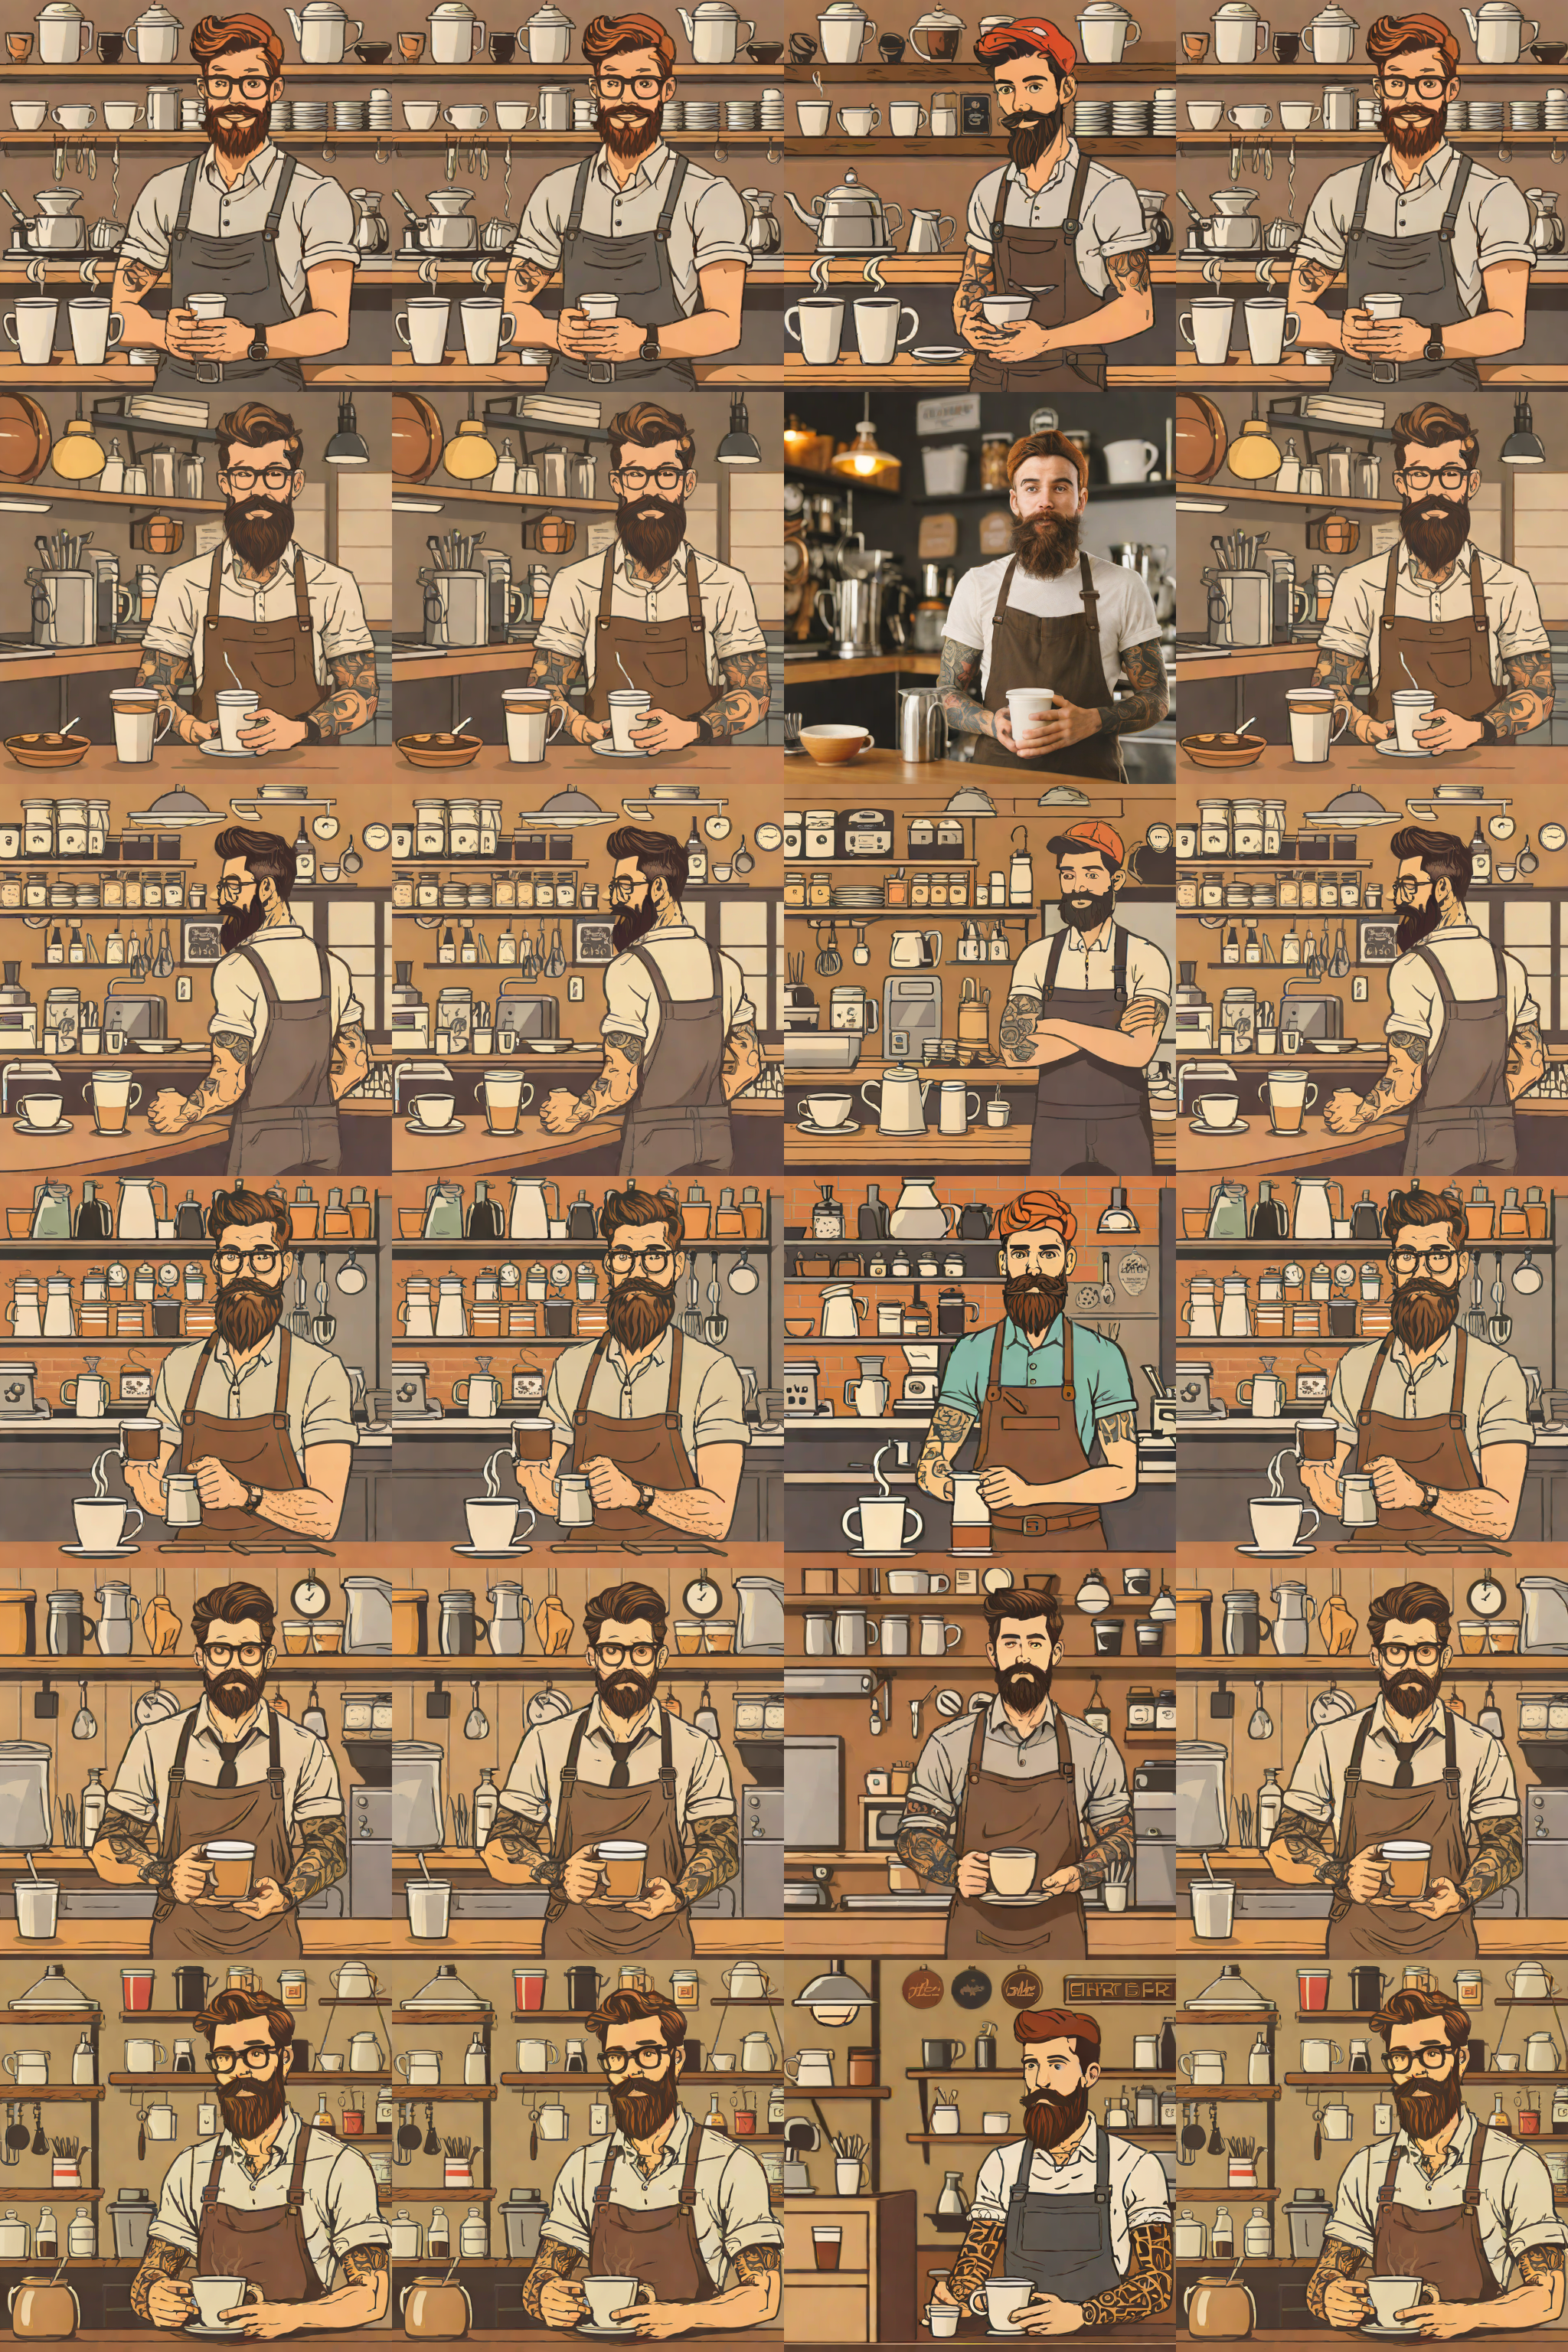

In [0]:
# Impactful NAG (timed mid-window + attention-space normalisation)
# Usage notes:
#   - Use (nag_start, nag_end) ≈ (0.15, 0.40) for noun/object negatives; try (0.30, 0.55) for adjective/style negatives
#   - For few-step samplers (1–4), prefer nag_scale in [3, 4], nag_tau≈2.5, nag_alpha≈0.25
#   - nag_window_steps turns NAG off K iterations after it starts (small, surgical burst)



import sys
import torch
from PIL import Image
from diffusers import (
    UNet2DConditionModel,
    StableDiffusionXLPipeline,
    EulerAncestralDiscreteScheduler,
)

# Add the workspace directory to sys.path (adjust if your project lives elsewhere)
workspace_dir = "/home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance"
if workspace_dir not in sys.path:
    sys.path.insert(0, workspace_dir)

%load_ext autoreload
%autoreload 2

from nag import ImpactfulNAGStableDiffusionXLPipeline

# ---------- Config ----------
device = "cuda"
weights_dtype = torch.bfloat16
basemodel_id = "stabilityai/stable-diffusion-xl-base-1.0"

# Turbo UNet source
turbo_repo = "stabilityai/sdxl-turbo"
turbo_subfolder = "unet"

# ---------- Base model (to borrow scheduler config) ----------
base_pipe_for_cfg = StableDiffusionXLPipeline.from_pretrained(
    basemodel_id, torch_dtype=weights_dtype, use_safetensors=True
)
base_sched_config = base_pipe_for_cfg.scheduler.config
del base_pipe_for_cfg  # keep VRAM tidy

# ---------- SDXL-Turbo distilled UNet ----------
distilled_unet = UNet2DConditionModel.from_pretrained(
    turbo_repo, subfolder=turbo_subfolder, torch_dtype=weights_dtype, variant="fp16"
).to(device, weights_dtype)

# ---------- Pipelines (EulerA for Turbo, trailing timesteps) ----------
pipe_impactful_nag_turbo = ImpactfulNAGStableDiffusionXLPipeline.from_pretrained(
    basemodel_id, unet=distilled_unet, torch_dtype=weights_dtype, variant="fp16", use_safetensors=True
).to(device)
pipe_impactful_nag_turbo.scheduler = EulerAncestralDiscreteScheduler.from_config(
    base_sched_config, timestep_spacing="trailing"
)

pipe_std_turbo = StableDiffusionXLPipeline.from_pretrained(
    basemodel_id, unet=distilled_unet, torch_dtype=weights_dtype, variant="fp16", use_safetensors=True
).to(device)
pipe_std_turbo.scheduler = EulerAncestralDiscreteScheduler.from_config(
    base_sched_config, timestep_spacing="trailing"
) 

# ---------- Prompts, seeds, and settings ----------
prompt = "Hipster coffee shop worker"
block_glasses = "glasses"
seeds = [2047, 2107, 2207, 2307, 2407, 2507]

STEPS = 4               # Turbo supports 1–4 steps; keep 4 to match your Lightning grid
TURBO_CFG = 0.0         # ADD-style; typically run with CFG ~0

# Impactful NAG timing parameters
NAG_START = 0.0        # Delay NAG start to 20% of trajectory (for object deletion)
                        # Try 0.30–0.40 for adjective/style negatives
NAG_RAMP_STEPS = 0      # Leave at 0 unless quality dip; try 3 if needed
NAG_SCALE = 3.0         # Standard NAG scale
NAG_END = 1.0           # Default: keep NAG on to the end

STD_BLOCKING_CFG = 1.0  # small CFG so negative_prompt has effect

rows = []
for s in seeds:
    # 1) Impactful NAG (Turbo UNet), no NAG negatives (pure Turbo sample)
    g = torch.Generator(device=device).manual_seed(s)
    img_impactful_1 = pipe_impactful_nag_turbo(
        prompt, guidance_scale=TURBO_CFG, generator=g, num_inference_steps=STEPS
    ).images[0]

    g = torch.Generator(device=device).manual_seed(s)
    img_impactful_2 = pipe_impactful_nag_turbo(
        prompt,
        nag_negative_prompt=block_glasses,
        nag_scale=NAG_SCALE,
        nag_start=0,
        nag_ramp_steps=NAG_RAMP_STEPS,
        nag_end=1,
        nag_cooldown=0.08,                # configured…
        nag_cooldown_cfg_drop=0.20,       # …but won’t change anything when CFG=0.0
        guidance_scale=0.0,               # <- this nullifies the cool-down effect
        num_inference_steps=STEPS,
        generator=g,
    ).images[0]

    g = torch.Generator(device=device).manual_seed(s)
    img_impactful_3 = pipe_impactful_nag_turbo(
        prompt,
        nag_negative_prompt=block_glasses,
        nag_scale=NAG_SCALE,
        nag_start=0.2,
        nag_ramp_steps=NAG_RAMP_STEPS,
        nag_end=0.8,
        guidance_scale=0.0,               # <- this nullifies the cool-down effect
        num_inference_steps=STEPS,
        generator=g,
    ).images[0]

    g = torch.Generator(device=device).manual_seed(s)
    img_impactful_2 = pipe_impactful_nag_turbo(
        prompt,
        nag_negative_prompt=block_glasses,
        nag_scale=NAG_SCALE,
        nag_start=0.2,
        nag_ramp_steps=NAG_RAMP_STEPS,
        nag_end=0.8,
        nag_cooldown=0.08,                # configured…
        nag_cooldown_cfg_drop=0.20,       # …but won’t change anything when CFG=0.0
        guidance_scale=0.0,               # <- this nullifies the cool-down effect
        num_inference_steps=STEPS,
        generator=g,
    ).images[0]

g = torch.Generator(device=device).manual_seed(s)
img_impactful_block = pipe_impactful_nag_turbo(
    prompt,
    nag_negative_prompt=block_glasses,
    nag_scale=NAG_SCALE,
    nag_start=NAG_START,
    nag_ramp_steps=NAG_RAMP_STEPS,
    nag_end=NAG_END,
    nag_cooldown=0.08,                # configured…
    nag_cooldown_cfg_drop=0.20,       # …but won’t change anything when CFG=0.0
    guidance_scale=0.0,               # <- this nullifies the cool-down effect
    num_inference_steps=STEPS,
    generator=g,
).images[0]


    # 4) STD with normal negative_prompt (small CFG so it bites a little)
    g = torch.Generator(device=device).manual_seed(s)
    img_std_block = pipe_std_turbo(
        prompt,
        negative_prompt=block_glasses,
        guidance_scale=STD_BLOCKING_CFG,
        num_inference_steps=STEPS,
        generator=g,
    ).images[0]

    rows.append([img_impactful_plain, img_std_plain, img_impactful_block, img_std_block])

# ---------- Assemble comparison grid (4 rows × 4 cols) ----------
img_height, img_width = rows[0][0].height, rows[0][0].width
grid = Image.new('RGB', (img_width * 4, img_height * 6))
for row_idx, row_images in enumerate(rows):
    for col_idx, img in enumerate(row_images):
        grid.paste(img, (col_idx * img_width, row_idx * img_height))

print("Comparison Grid Layout (Impactful NAG; SDXL-Turbo, 4-step):")
print("Column 1: Impactful NAG (no negatives) | Column 2: STD (no negatives)")
print("Column 3: Impactful NAG + blocking     | Column 4: STD + blocking")
print(f"  nag_start={NAG_START}, nag_ramp_steps={NAG_RAMP_STEPS}, nag_end={NAG_END}")
print(f"Row 1: Seed {seeds[0]} | Row 2: Seed {seeds[1]} | Row 3: Seed {seeds[2]} | Row 4: Seed {seeds[3]}")
grid
